In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from collections import Counter
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score # accuracy_score ajouté

In [18]:

## 2. Chargement et analyse du dataset
# Chargement du dataset complet
# df = pd.read_csv('dataset_complet.csv', sep=';') # OLD LINE
df = pd.read_csv('dataset_prepared.csv', sep=',') # MODIFIED: Nom de fichier et séparateur
if 'Unnamed: 0' in df.columns: # AJOUTÉ: Gestion de la colonne d'index potentielle
    df = df.drop(columns=['Unnamed: 0'])
# ...existing code...
# print(df.head())
# print('\\nInformations générales :')
# print(df.info())
# print('\\nStatistiques descriptives :')
# print(df.describe())
print("Aperçu du dataset:") 
print(df.head())
print('\\nInformations générales :\\n') 
df.info() 
print('\\nStatistiques descriptives :\\n') 
print(df.describe(include='all'))

## 3. Filtrage des colonnes pertinentes
# print('Colonnes disponibles :', df.columns.tolist()) 
# Sélection des features météo et statiques
# weather_cols = ['tempmax', 'tempmin', 'precip', 'humidity', 'windspeed', 'pressure', 'cloudcover'] # OLD
# static_cols = ['latitude_centroid', 'longitude_centroid'] # OLD
# target_col = 'label'
# # longueur de la séquence et horizon de prédiction
# SEQ_LEN = 10  # nombre de pas temporels en entrée # OLD
# HORIZON = 7   # prédiction à HORIZON jours # OLD
# features = weather_cols + static_cols # OLD
# df_sel = df[['chemin_directory', 'date'] + weather_cols + static_cols + [target_col]].copy() # OLD
# df_sel['date'] = pd.to_datetime(df_sel['date'], dayfirst=True) # OLD
# df_sel.sort_values(['chemin_directory','date'], inplace=True) # OLD
# print('Colonnes disponibles :', df.columns.tolist()) # OLD, repeated
# print(df_sel.head()) # OLD
print('\\nColonnes disponibles après chargement :', df.columns.tolist())

# MODIFIÉ: Définition des colonnes à utiliser et à exclure
# Colonnes à exclure explicitement de l'entraînement direct
# (certaines comme 'date' et 'chemin_directory' sont utilisées pour le traitement)
cols_to_exclude_from_features = [
    'Unnamed: 0', 'geometry', 'tile_number', 'id', 'location_id', 
    'image_dir', 'date_satellites_S1', 'nouveau_chemin', 
    'latitude_centroid', 'longitude_centroid', # Exclues des features directes
    'source', 'timezone', 'folder'
]

# Colonnes météorologiques à utiliser
weather_cols = ['tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity', 'precipprob', 'precipcover', 'windspeed', 'winddir', 'pressure', 'cloudcover', 'visibility']
# S'assurer que seules les colonnes présentes dans le df sont gardées
weather_cols = [col for col in weather_cols if col in df.columns]

# Colonnes statiques à utiliser (uniquement l'élévation comme demandé)
static_cols = ['elevation']
static_cols = [col for col in static_cols if col in df.columns]

# Colonne catégorielle à utiliser
categorical_cols = ['soil_type']
categorical_cols = [col for col in categorical_cols if col in df.columns]

target_col = 'label' 

SEQ_LEN = 6  

# Colonnes à conserver initialement pour le traitement
# Inclut celles nécessaires pour le groupement/tri, les features, et la target.
initial_cols_to_keep = ['chemin_directory', 'date'] + weather_cols + static_cols + categorical_cols + [target_col]
# Filtrer pour ne garder que les colonnes existantes dans le DataFrame
initial_cols_to_keep = [col for col in initial_cols_to_keep if col in df.columns]
df_processed = df[initial_cols_to_keep].copy()

print(f"\\nColonnes conservées pour le traitement initial: {df_processed.columns.tolist()}")

df_processed['date'] = pd.to_datetime(df_processed['date'], format='%d/%m/%Y') 
df_processed.sort_values(['chemin_directory', 'date'], inplace=True)

# AJOUTÉ: Encodage One-Hot pour 'soil_type'
if 'soil_type' in df_processed.columns:
    df_processed = pd.get_dummies(df_processed, columns=categorical_cols, prefix='soil', dummy_na=False) # dummy_na=False pour ne pas créer de colonne pour NaN
    soil_one_hot_cols = [col for col in df_processed.columns if col.startswith('soil_')]
    print(f"\\nColonnes après encodage One-Hot de 'soil_type': {soil_one_hot_cols}")
else:
    soil_one_hot_cols = []
    print("\\nLa colonne 'soil_type' n'est pas présente, pas d'encodage One-Hot.")

# Imputation des données manquantes
numerical_features_to_impute = weather_cols + static_cols 
print(f"\\nImputation des valeurs manquantes pour les colonnes numériques: {numerical_features_to_impute}")
for col in numerical_features_to_impute: 
    if col in df_processed.columns: 
        df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce')
        # S'assurer que le groupement ne se fait pas sur une colonne qui n'existe plus si elle a été enlevée
        if 'chemin_directory' in df_processed.columns:
            df_processed[col] = df_processed.groupby('chemin_directory')[col].transform(
                lambda x: x.interpolate(method='linear', limit_direction='both').bfill().ffill()
            )
        else: # Au cas où chemin_directory aurait été retiré par erreur plus tôt
            df_processed[col] = df_processed[col].interpolate(method='linear', limit_direction='both').bfill().ffill()

        if df_processed[col].isnull().any():
            print(f"Attention: NaN restants dans {col} après interpolation, remplissage par la moyenne globale.")
            df_processed[col] = df_processed[col].fillna(df_processed[col].mean())
    else:
        print(f"Attention: La colonne {col} n'est pas présente dans df_processed pour l'imputation.")

# MODIFIÉ: Définition des colonnes pour les séquences X
# Inclut les features météo, statiques (elevation), soil_type (one-hot) et le label des jours précédents
feature_columns_for_X = weather_cols + static_cols + soil_one_hot_cols + [target_col]
# S'assurer que toutes les colonnes existent dans df_processed
feature_columns_for_X = [col for col in feature_columns_for_X if col in df_processed.columns]
print(f"\\nColonnes utilisées pour construire les séquences X: {feature_columns_for_X}")

# AJOUTÉ: Vérification des NaN après imputation
print("\\nNaN restants avant création des séquences (uniquement les colonnes pour X):")
if feature_columns_for_X: # Vérifier que la liste n'est pas vide
    print(df_processed[feature_columns_for_X].isnull().sum().sort_values(ascending=False))
    # Optionnel mais recommandé: supprimer les lignes où des NaN persistent dans les features ou la target
    df_processed.dropna(subset=feature_columns_for_X + [target_col], inplace=True)
    print(f"Forme de df_processed après dropna: {df_processed.shape}")
else:
    print("Aucune colonne de feature sélectionnée pour X, vérifiez les étapes précédentes.")


# Construction des fenêtres glissantes (pas=1) pour chaque région
# def build_xy_windows(df_sel): # OLD FUNCTION
#     X, y = [], []
#     for r, grp in df_sel.groupby('chemin_directory'):
#         arr = grp.sort_values('date')[features].values
#         lbl = grp.sort_values('date')[target_col].values
#         for i in range(len(arr) - SEQ_LEN - HORIZON + 1):
#             X.append(arr[i:i+SEQ_LEN])
#             y.append(lbl[i+SEQ_LEN+HORIZON-1])
#     return np.array(X), np.array(y)
# X_all, y_all = build_xy_windows(df_sel) # OLD CALL
# print('Total sequences :', X_all.shape[0]) # OLD

# NOUVELLE fonction pour construire les séquences
def build_sequences(df_data, feature_cols_for_x_step, target_label_col, seq_length):
    X_list, y_list = [], []
    for _, group in df_data.groupby('chemin_directory'):
        features_values = group[feature_cols_for_x_step].values
        target_values = group[target_label_col].values
        if len(features_values) >= seq_length + 1:
            for i in range(len(features_values) - seq_length):
                X_list.append(features_values[i : i + seq_length])
                y_list.append(target_values[i + seq_length])
    return np.array(X_list), np.array(y_list)

print(f"\\nCréation des séquences avec SEQ_LEN={SEQ_LEN}...") # AJOUTÉ
X_all, y_all = build_sequences(df_processed, feature_columns_for_X, target_col, SEQ_LEN) # NOUVEL APPEL

print('Total des séquences créées :', X_all.shape[0]) # MODIFIED PRINT (from old)
if X_all.shape[0] == 0: # AJOUTÉ: Vérification si des séquences sont créées
    print("Aucune séquence n'a pu être créée. Vérifiez les données et SEQ_LEN.")
    exit()
print('Shape de X_all :', X_all.shape) # AJOUTÉ
print('Shape de y_all :', y_all.shape) # AJOUTÉ



Aperçu du dataset:
                                            geometry  label        date  \
0  [[[34.811154, -19.680618], [34.811675, -19.726...      0  06/02/2019   
1  [[[34.811154, -19.680618], [34.811675, -19.726...      0  07/02/2019   
2  [[[34.811154, -19.680618], [34.811675, -19.726...      0  08/02/2019   
3  [[[34.811154, -19.680618], [34.811675, -19.726...      0  09/02/2019   
4  [[[34.811154, -19.680618], [34.811675, -19.726...      0  10/02/2019   

   tile_number                                  id  location_id  \
0          0.0  sen12floods_s1_labels_0_2019_02_06          0.0   
1          0.0  sen12floods_s1_labels_0_2019_02_06          0.0   
2          0.0  sen12floods_s1_labels_0_2019_02_06          0.0   
3          0.0  sen12floods_s1_labels_0_2019_02_06          0.0   
4          0.0  sen12floods_s1_labels_0_2019_02_06          0.0   

                                           image_dir chemin_directory  \
0  ../input/sen12flood/sen12flood/sen12floods_s1_...  

In [19]:

# 3) Split temporel (60/20/20)
n = len(X_all)
idx1 = int(n * 0.6)
idx2 = int(n * 0.8)
X_train, y_train = X_all[:idx1], y_all[:idx1]
X_val,   y_val   = X_all[idx1:idx2], y_all[idx1:idx2]
X_test,  y_test  = X_all[idx2:], y_all[idx2:]
print('Train/Val/Test shapes :', X_train.shape, X_val.shape, X_test.shape)


Train/Val/Test shapes : (7885, 6, 32) (2628, 6, 32) (2629, 6, 32)


In [20]:
# 4) Afficher distribution des classes
from collections import Counter
print('Distribution y_train :', Counter(y_train))

Distribution y_train : Counter({np.int64(0): 5525, np.int64(1): 2360})


In [21]:
# 5) Normaliser sur X_train seulement
scaler = MinMaxScaler()
flat = X_train.reshape(-1, X_train.shape[2])
scaler.fit(flat)
def scale_set(X): return scaler.transform(X.reshape(-1, X.shape[2])).reshape(X.shape)
X_train = scale_set(X_train)
X_val   = scale_set(X_val)
X_test  = scale_set(X_test)

In [22]:
# 6) Calcul du class_weight
from sklearn.utils import class_weight # Assurer l'import
cw = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), cw))
print('Class weights :', class_weight_dict)

## 6. Construction de l'architecture LSTM
F = X_all.shape[2] # MODIFIÉ: Utiliser X_all pour F car X_train n'est pas encore défini ici
model = Sequential([
    Bidirectional(LSTM(32), input_shape=(SEQ_LEN, F)), # MODIFIED: F
    Dense(1, activation='sigmoid') # MODIFIED: 1 neurone pour la classification binaire
]) # CROCHET FERMANT AJOUTÉ ICI
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC', 'accuracy']) # AJOUTÉ: 'accuracy'
model.summary()


Class weights : {np.int64(0): np.float64(0.7135746606334842), np.int64(1): np.float64(1.6705508474576272)}


d:\dataset\SEN12FLOOD (1)\env311\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,705 (65.25 KB)

 Trainable params: 16,705 (65.25 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
## 7. Entraînement du modèle
early = EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=16,
    class_weight=class_weight_dict, # MODIFIÉ: Utilisation de class_weight_dict calculé dynamiquement
    callbacks=[early]
)


Epoch 1/50
493/493 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9317 - accuracy: 0.8750 - loss: 0.2794 - val_AUC: 0.9907 - val_accuracy: 0.9696 - val_loss: 0.0898
Epoch 2/50
493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9941 - accuracy: 0.9889 - loss: 0.0619 - val_AUC: 0.9828 - val_accuracy: 0.9802 - val_loss: 0.0973
Epoch 3/50
493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9956 - accuracy: 0.9897 - loss: 0.0560 - val_AUC: 0.9925 - val_accuracy: 0.9756 - val_loss: 0.0761
Epoch 4/50
493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9969 - accuracy: 0.9918 - loss: 0.0479 - val_AUC: 0.9933 - val_accuracy: 0.9745 - val_loss: 0.0795
Epoch 5/50
493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9960 - accuracy: 0.9875 - loss: 0.0572 - val_AUC: 0.9862 - val_accuracy: 0.9802 - val_loss: 0.0837
Epoch 6/50
493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9971 - accuracy: 0.9898 - loss: 0.0497 - val_AUC: 0.9943 - val_accuracy: 0.9791 - val_loss: 0.0671
Epoch 7/50
493/493 ━━━━━━━━━━━━━━━━━━━━ 

83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1763
           1       0.99      0.98      0.99       866

    accuracy                           0.99      2629
   macro avg       0.99      0.99      0.99      2629
weighted avg       0.99      0.99      0.99      2629

AUC : 0.9969929746561013
Accuracy : 0.9904906808672499
Matrice de confusion :\n [[1757    6]
 [  19  847]]


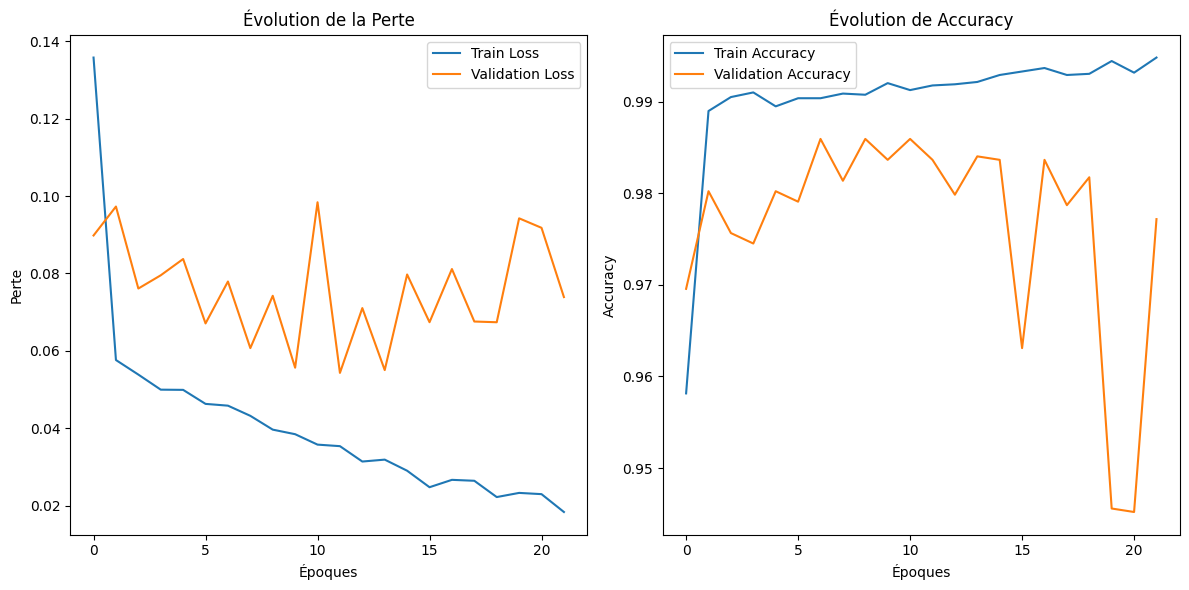

In [24]:

## 8. Évaluation des performances du modèle
# y_pred = (model.predict(X_test).max(axis=1) > 0.5).astype(int) # OLD
# print(classification_report(y_test, y_pred)) # OLD
# print('AUC :', roc_auc_score(y_test, model.predict(X_test).max(axis=1))) # OLD
# print('Accuracy :', np.mean(y_pred == y_test)) # OLD

y_pred_proba = model.predict(X_test) # NOUVELLE logique de prédiction
y_pred = (y_pred_proba > 0.5).astype(int)

print(classification_report(y_test, y_pred)) # Inchangé mais contexte de y_pred change
print('AUC :', roc_auc_score(y_test, y_pred_proba)) # MODIFIÉ: utilise y_pred_proba
print('Accuracy :', accuracy_score(y_test, y_pred)) # MODIFIÉ: utilise accuracy_score
cm = confusion_matrix(y_test, y_pred) # AJOUTÉ
print('Matrice de confusion :\\n', cm) # AJOUTÉ

# Visualisation de l'évolution de la perte et de la précision
plt.figure(figsize=(12, 6)) # MODIFIÉ: Taille
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Val Loss') # OLD
plt.plot(history.history['val_loss'], label='Validation Loss') # MODIFIÉ: Label
# plt.title('Loss') # OLD
plt.title('Évolution de la Perte') # MODIFIÉ: Titre
# plt.xlabel('Epochs') # OLD
plt.xlabel('Époques') # MODIFIÉ: Label
# plt.ylabel('Loss') # OLD
plt.ylabel('Perte') # MODIFIÉ: Label
plt.legend()
plt.subplot(1, 2, 2)
# plt.plot(history.history['accuracy'], label='Train Accuracy') # OLD
# plt.plot(history.history['val_accuracy'], label='Val Accuracy') # OLD
# plt.title('Accuracy') # OLD
# plt.xlabel('Epochs') # OLD
# plt.ylabel('Accuracy') # OLD
# plt.legend()
# NOUVELLE logique pour afficher la bonne métrique (accuracy ou AUC)
metric_to_plot = ''
if 'accuracy' in history.history:
    metric_to_plot = 'accuracy'
elif 'auc' in history.history: # Gérer les variations de nom pour AUC (ex: auc_1)
    auc_keys = [key for key in history.history.keys() if 'auc' in key.lower() and 'val' not in key.lower()]
    if auc_keys:
        metric_to_plot = auc_keys[0]

if metric_to_plot:
    val_metric_to_plot = f'val_{metric_to_plot}'
    if metric_to_plot in history.history and val_metric_to_plot in history.history:
        plt.plot(history.history[metric_to_plot], label=f'Train {metric_to_plot.capitalize()}')
        plt.plot(history.history[val_metric_to_plot], label=f'Validation {metric_to_plot.capitalize()}')
        plt.title(f'Évolution de {metric_to_plot.capitalize()}')
        plt.xlabel('Époques')
        plt.ylabel(metric_to_plot.capitalize())
        plt.legend()
    else:
        print(f"Clés de métrique '{metric_to_plot}' ou '{val_metric_to_plot}' non trouvées dans history.history.")
else:
    print("Métrique ('accuracy' ou 'auc') non trouvée dans history.history pour le graphique.")

plt.tight_layout()
plt.show()


In [25]:
## 9. Enregistrement du modèle pour une utilisation ultérieure
# model.save('lstm_inondation.h5') # OLD
model.save('lstm_inondation_v2.h5') # MODIFIÉ: Nom de modèle
# print('Modèle enregistré : lstm_inondation.h5') # OLD
print('Modèle enregistré : lstm_inondation_v2.h5') # MODIFIÉ: Message

Modèle enregistré : lstm_inondation_v2.h5


In [29]:
# ## 10. Test avec un exemple spécifique et Évaluation des transitions 0 -> 1 sur X_test
print("\\n## 10. Test et Évaluation des transitions 0 -> 1 sur X_test")

from tensorflow.keras.models import load_model
# Assurez-vous que MinMaxScaler est disponible si vous devez le recharger,
# mais idéalement, l'objet 'scaler' des cellules précédentes est utilisé.
# from sklearn.preprocessing import MinMaxScaler # Déjà importé globalement

# --- Chargement du modèle et vérification du scaler ---
model_path = 'lstm_inondation_v3.h5'
try:
    model = load_model(model_path)
    print(f"Modèle '{model_path}' chargé avec succès.")
except Exception as e:
    print(f"Erreur lors du chargement du modèle '{model_path}': {e}")
    print("Assurez-vous que le modèle a été correctement sauvegardé et que le chemin est correct.")
    exit() # Quitter si le modèle ne peut pas être chargé

# Vérification de l'existence et de l'état de l'objet 'scaler'
# Ce scaler doit être celui qui a été 'fit' sur les données d'entraînement du modèle v3 (X_train_smote).
if 'scaler' not in globals(): # Vérifier si scaler est dans la portée globale
    print("ERREUR: L'objet 'scaler' n'est pas défini dans la portée globale.")
    print("Si le scaler a été sauvegardé séparément (ex: avec joblib), chargez-le ici.")
    # Exemple: import joblib; scaler = joblib.load('min_max_scaler_v3.gz')
    exit()
# Vérification basique si le scaler a été fitté (pour MinMaxScaler)
if not hasattr(scaler, 'data_min_') or not hasattr(scaler, 'data_max_'):
     print("ATTENTION: Le scaler ne semble pas avoir été ajusté ('fit') correctement ou est d'un type inattendu.")
     print("Les résultats de la mise à l'échelle pourraient être incorrects.")
     # exit() # Optionnel: arrêter si le scaler n'est pas bon

# --- Évaluation généralisée des transitions 0 -> 1 sur le jeu de test (X_test) ---
print("\\n## Évaluation spécifique des transitions 0 -> 1 sur le jeu de test (X_test)")

# Assurez-vous que X_test, y_test sont disponibles et correctement formés/scalés
if 'X_test' not in globals() or 'y_test' not in globals():
    print("ERREUR: X_test ou y_test ne sont pas définis. Vérifiez les étapes de préparation des données.")
    exit()
elif 'target_col' not in globals() or 'feature_columns_for_X' not in globals():
    print("ERREUR: target_col ou feature_columns_for_X ne sont pas définis.")
    exit()
elif X_test.shape[0] == 0:
    print("ERREUR: X_test est vide.")
    exit()
else:
    if target_col not in feature_columns_for_X:
        print(f"Erreur : La colonne cible '{target_col}' n'est pas dans 'feature_columns_for_X'. Impossible de procéder à l'évaluation des transitions sur X_test.")
        exit()
    else:
        label_idx_in_features = feature_columns_for_X.index(target_col)

        TP_transitions = 0  # Vrais Positifs pour les transitions 0->1
        FP_transitions = 0  # Faux Positifs (prédit 1 après un 0, mais réel était 0 après un 0)
        FN_transitions = 0  # Faux Négatifs (prédit 0 après un 0, mais réel était 1 après un 0)
        
        actual_0_to_1_transitions_count = 0 # Compteur des transitions 0->1 réelles dans X_test
        
        print(f"Analyse de {len(y_test)} échantillons dans X_test/y_test pour les transitions où le 6ème jour d'input est 0...")

        # Batch predict pour l'efficacité
        y_pred_proba_test = model.predict(X_test)
        y_pred_label_test = (y_pred_proba_test > 0.5).astype(int).flatten()

        for i in range(len(y_test)):
            current_X_sequence_scaled = X_test[i] # Déjà scalé
            actual_label_day7 = y_test[i]
            predicted_label_day7 = y_pred_label_test[i]
            
            label_day6_in_sequence_scaled = current_X_sequence_scaled[-1, label_idx_in_features]
            label_day6_in_sequence_approx = np.round(label_day6_in_sequence_scaled).astype(int)

            if label_day6_in_sequence_approx == 0:
                if actual_label_day7 == 1: 
                    actual_0_to_1_transitions_count += 1
                    if predicted_label_day7 == 1:
                        TP_transitions += 1
                    else: 
                        FN_transitions += 1
                else: # actual_label_day7 == 0
                    if predicted_label_day7 == 1:
                        FP_transitions += 1
        
        print(f"\\n--- Fin de l'analyse des transitions sur X_test ---")
        if actual_0_to_1_transitions_count == 0 and (TP_transitions + FP_transitions) == 0:
             print("Aucune transition réelle 0->1 (où le 6ème jour d'input était 0) ni prédiction de type 0->1 n'a été trouvée ou traitée dans le jeu de test selon les critères.")
        else:
            print(f"Nombre total de séquences dans X_test où le 6ème jour d'input avait un label approx. de 0.")
            print(f"  Parmi celles-ci, nombre de transitions réelles 0 -> 1 : {actual_0_to_1_transitions_count}")
            
            print(f"Vrais Positifs (TP) pour les transitions 0->1 (0->1 prédit comme 0->1) : {TP_transitions}")
            print(f"Faux Positifs (FP) pour les transitions (0->0 prédit comme 0->1) : {FP_transitions}")
            print(f"Faux Négatifs (FN) pour les transitions (0->1 prédit comme 0->0) : {FN_transitions}")

            precision_transitions = TP_transitions / (TP_transitions + FP_transitions) if (TP_transitions + FP_transitions) > 0 else 0.0
            recall_transitions = TP_transitions / actual_0_to_1_transitions_count if actual_0_to_1_transitions_count > 0 else 0.0

            print(f"Précision pour la détection des transitions 0->1 (conditionnée au 6ème jour=0) : {precision_transitions:.4f}")
            print(f"Rappel pour la détection des transitions 0->1 (conditionnée au 6ème jour=0) : {recall_transitions:.4f}")

            if (precision_transitions + recall_transitions) > 0:
                f1_score_transitions = 2 * (precision_transitions * recall_transitions) / (precision_transitions + recall_transitions)
                print(f"Score F1 pour la détection des transitions 0->1 (conditionnée au 6ème jour=0) : {f1_score_transitions:.4f}")
            else:
                print("Score F1 pour la détection des transitions 0->1 (conditionnée au 6ème jour=0) : 0.0000")

print("\\nFin du script d'entraînement et d'évaluation.")

\n## 10. Test et Évaluation des transitions 0 -> 1 sur X_test
Modèle 'lstm_inondation_v3.h5' chargé avec succès.
ATTENTION: Le scaler ne semble pas avoir été ajusté ('fit') correctement ou est d'un type inattendu.
Les résultats de la mise à l'échelle pourraient être incorrects.
\n## Évaluation spécifique des transitions 0 -> 1 sur le jeu de test (X_test)
Analyse de 2629 échantillons dans X_test/y_test pour les transitions où le 6ème jour d'input est 0...
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
\n--- Fin de l'analyse des transitions sur X_test ---
Nombre total de séquences dans X_test où le 6ème jour d'input avait un label approx. de 0.
  Parmi celles-ci, nombre de transitions réelles 0 -> 1 : 27
Vrais Positifs (TP) pour les transitions 0->1 (0->1 prédit comme 0->1) : 11
Faux Positifs (FP) pour les transitions (0->0 prédit comme 0->1) : 26
Faux Négatifs (FN) pour les transitions (0->1 prédit comme 0->0) : 16
Précision pour la détection des transitions 0->1 (conditionnée au 6ème jour=0) :